# MLP training on MNIST

1.   Testing on all 10000 images,because faster. Problem?
2.   Listeneintrag



In [9]:
import numpy as np
import jax.numpy as jnp
from jax.scipy.special import logsumexp
import jax
import _pickle as cPickle
import pickle
import copy
from jax import jit, vmap, pmap, grad, value_and_grad
import random
from torchvision.datasets import MNIST
from torchvision.datasets import KMNIST
from torchvision.datasets import CIFAR100
from torchvision.datasets import EMNIST
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from jax.example_libraries import stax, optimizers
import torchvision
import torch
from sklearn.neighbors import NearestNeighbors
import torch.utils.data as data_utils
from jax.flatten_util import ravel_pytree
import os
import time
import shutil
import _pickle as cPickle
from math import e
import time
from jax.example_libraries import stax
from jax.example_libraries.stax import Dense, Relu, LogSoftmax
from sklearn.model_selection import train_test_split
from jax import random 
import matplotlib.pyplot as plt
from torchvision import transforms
from logging import Logger
import time
import itertools

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Funktions**

Changes in Jax Jit function (sometimes?) need a cache restart for changes to be applied. Happened with def accuracy

In [11]:
def logg_to_file (string_, array=None):
  if array is None:

    file1 = open(save_txt,"a")
    file1.write(string_)
    file1.write("\n")
    file1.close()
    
  if array is not None:

    file1 = open(save_txt,"a")
    file1.write(string_)
    file1.write(str(array))
    file1.write("\n")
    file1.close()

def log_variables():
    try:
    
      logg_to_file (("n_training_epochs = {}".format(n_training_epochs)))
      logg_to_file (("n_offsp_epoch = {}".format(n_offsp_epoch)))
      
      logg_to_file (("n_samples = {}".format(n_samples)))
      logg_to_file (("n_test = {}".format(n_test)))
      logg_to_file (("batch_size = {}".format(batch_size)))

      logg_to_file (("use_focus = {}".format(use_focus)))
      #logg_to_file (("focus_layer = {}".format(focus_layer)))
      logg_to_file (("focus_change_every = {}".format(focus_change_every)))

      
      logg_to_file (("use_sigma_decay = {}".format(use_sigma_decay)))
      logg_to_file (("n_decay_epochs = {}".format(n_decay_epochs)))
      logg_to_file (("sigma_start = {}".format(sigma_start)))
      logg_to_file (("sigma_goal = {}".format(sigma_goal)))

    
      logg_to_file (("use_KNN = {}".format(use_KNN)))
      logg_to_file (("KNN_n_neighbors = {}".format(KNN_n_neighbors)))
      logg_to_file (("KNN_top_n = {}".format(KNN_top_n)))
      logg_to_file (("n_KNN_subsprings = {}".format(n_KNN_subsprings)))




      logg_to_file (("std_modifier = {}".format(std_modifier)))
      logg_to_file (("use_sigma_decay = {}".format(use_sigma_decay)))
      logg_to_file (("sigma_start = {}".format(sigma_start)))
      logg_to_file (("sigma_goal = {}".format(sigma_goal)))
      logg_to_file (("n_decay_epochs = {}".format(n_decay_epochs)))
      logg_to_file (("use_pickle = {}".format(use_pickle)))
      logg_to_file (("pickle_path = {}".format(pickle_path)))
      logg_to_file (("use_father = {}".format(use_father)))


      logg_to_file (("NNin1 = {}".format(NNin1)))
      logg_to_file (("NNout1 = {}".format(NNout1)))
      logg_to_file (("Convu_in1 = {}".format(Convu1_in)))
      logg_to_file (("Convu2_in = {}".format(Convu2_in)))
      logg_to_file (("Convu3_in = {}".format(Convu3_in)))

      logg_to_file (("kernelsize_ = {}".format(kernelsize_)))
      
      logg_to_file (("n_metaepochs = {}".format(n_metaepochs)))
      logg_to_file (("n_testing_epochs = {}".format(n_testing_epochs)))         
      logg_to_file (("n_offsp_epoch = {}".format(n_offsp_epoch)))
      logg_to_file (("n_offsprings = {}".format(n_offsprings)))

      logg_to_file (("use_softmax = {}".format(use_softmax)))
      logg_to_file (("temperature = {}".format(temperature)))
    except Exception:
      pass

def pathandstuff():

    global save_txt
    global base_path
    global save_path

    if os.path.exists(googledrive_path):
        print("on google")
        base_path=googledrive_path
    else:
        raise ValueError('Please specify save path or connect to Google Drive')
        
    logs_path=base_path+costum_name
    '''Set logging and temp paths'''
    timestamp=time.strftime("%d.%m.%Y_%H.%M")
    foldername=timestamp
    save_path=os.path.join(logs_path,foldername,)
    save_path=save_path+"/"
    save_txt = os.path.join(save_path, 'Log_Jax_MNist_{}.txt'.format(foldername))

   # if use_paralleltraining:
      #save_path=parallel_path
      #save_txt = os.path.join(save_path, 'Log_Jax_MNist_{}.txt'.format(file_name))
      
      
    print("Log path:",save_path)
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    




def logg_script(file_name, save_path):
  source=f"/content/drive/MyDrive/Colab Notebooks/{file_name}"
  destination=save_path+f"{file_name}.ipynb"
  shutil.copy2(source, destination)

'''logging to txt and print'''
def logg (string_, array=None):
  if array is None:

    file1 = open(save_txt,"a")
    file1.write(string_)
    file1.write("\n")
    file1.close()
    print(string_)
  if array is not None:

    file1 = open(save_txt,"a")
    file1.write(string_)
    file1.write(str(array))
    file1.write("\n")
    file1.close()
    print(string_, array)

In [12]:
data_image_size=28
data_image_depth=1

train_dataset_EMNIST = EMNIST(root='train_emnist', train=True, download=True,split="balanced", transform=torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor(),
                                            transforms.Normalize((0.1307,), (0.3081,))
                                            ]))

test_dataset_EMNIST = EMNIST(root='test_emnist', train=False, download=True,split="balanced",transform=torchvision.transforms.Compose([
                                           torchvision.transforms.ToTensor(),
                                           transforms.Normalize((0.1307,), (0.3081,))
                                           ]))

train_dataset_KMNIST = KMNIST(root='train_kmnist', train=True, download=True,transform=torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor(),
                                            transforms.Normalize((0.1307,), (0.3081,))
                                            ]))

test_dataset_KMNIST = KMNIST(root='test_kmnist', train=False, download=True,transform=torchvision.transforms.Compose([
                                           torchvision.transforms.ToTensor(),
                                           transforms.Normalize((0.1307,), (0.3081,))
                                           ]))

'''Relabel KMNIST to avoid overlaps'''
map_dic = dict(zip([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [47,48,49,50,51,52,53,54,55,56]))
train_dataset_KMNIST.targets = np.vectorize(map_dic.get)(np.array(train_dataset_KMNIST.targets))
train_dataset_KMNIST.targets = torch.from_numpy(train_dataset_KMNIST.targets)


test_dataset_KMNIST.targets = np.vectorize(map_dic.get)(np.array(test_dataset_KMNIST.targets))
test_dataset_KMNIST.targets = torch.from_numpy(test_dataset_KMNIST.targets)


x = np.concatenate((train_dataset_EMNIST.data,
                    test_dataset_EMNIST.data,
                    train_dataset_KMNIST.data,
                    test_dataset_KMNIST.data
                    ))

y= np.concatenate((train_dataset_EMNIST.targets,
                   test_dataset_EMNIST.targets,
                   train_dataset_KMNIST.targets,
                   test_dataset_KMNIST.targets
                   ))

print("Number of different classes:", len(list(set(list(np.array(y))))))

Number of different classes: 57


In [31]:
train_dataset_EMNIST.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   1,   7,  32,  36,  21,   3,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   8,  33, 113, 124,  81,  22,   7,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   2,  77, 158, 243, 249, 232, 159,  95,
          34,  20,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   4, 124, 213, 254, 254, 254, 247, 234,
         202, 154,  23,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   4, 11

In [33]:
np.shape(train_dataset_KMNIST.data[0])

torch.Size([28, 28])

46


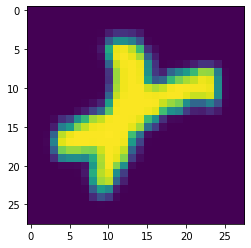

In [14]:
'''Show image and label'''
idx=10
plt.imshow(transforms.ToPILImage()(x[idx]))
print(y[idx])

In [15]:
def init_MLP(layer_widths, parent_key, scale=0.01):

    params = []
    keys = jax.random.split(parent_key, num=len(layer_widths)-1)

    for in_width, out_width, key in zip(layer_widths[:-1], layer_widths[1:], keys):
        weight_key, bias_key = jax.random.split(key)
        params.append([
                       scale*jax.random.normal(weight_key, shape=(out_width, in_width)),
                       scale*jax.random.normal(bias_key, shape=(out_width,))
                       ]
        )
    return params



In [16]:
@jit
def MLP_predict(params, x):

    hidden_layers = params[:-1]
    activation = x

    for w, b in hidden_layers:
        activation = jax.nn.relu(jnp.dot(w, activation) + b)

    w_last, b_last = params[-1]
    logits = jnp.dot(w_last, activation) + b_last

    return logits - logsumexp(logits)

jit_MLP_predict=jit(MLP_predict)

@jit
def batched_MLP_predict(params,x):
  return vmap(jit_MLP_predict, (None, 0))(params,x)
  
jit_batched_MLP_predict=jit(batched_MLP_predict)


In [17]:
'''Convu1_in=16
Convu2_in=24
Convu3_in=1

kernelsize_=(4,4)
batch_size = 50
n_offsp_epoch = 10
n_samples = 150

conv_init, conv_apply = stax.serial(
    stax.Conv(Convu1_in,kernelsize_, padding="SAME"),
    stax.BatchNorm(),
    stax.Relu,
    stax.MaxPool((2,2)),
    stax.Conv(Convu2_in, kernelsize_, padding="SAME"),
    stax.BatchNorm(),
    stax.Relu,
    stax.MaxPool((2,2)),
    stax.Conv(Convu3_in, kernelsize_, padding="SAME"),
    stax.Relu,
    stax.MaxPool((4,4)),
    stax.MaxPool((4,4)),
    stax.MaxPool((5,5))
)
'''

'Convu1_in=16\nConvu2_in=24\nConvu3_in=1\n\nkernelsize_=(4,4)\nbatch_size = 50\nn_offsp_epoch = 10\nn_samples = 150\n\nconv_init, conv_apply = stax.serial(\n    stax.Conv(Convu1_in,kernelsize_, padding="SAME"),\n    stax.BatchNorm(),\n    stax.Relu,\n    stax.MaxPool((2,2)),\n    stax.Conv(Convu2_in, kernelsize_, padding="SAME"),\n    stax.BatchNorm(),\n    stax.Relu,\n    stax.MaxPool((2,2)),\n    stax.Conv(Convu3_in, kernelsize_, padding="SAME"),\n    stax.Relu,\n    stax.MaxPool((4,4)),\n    stax.MaxPool((4,4)),\n    stax.MaxPool((5,5))\n)\n'

In [18]:
!nvidia-smi

Thu Aug 25 13:34:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [19]:
Convu1_in=32
Convu2_in=64


kernelsize_=(3,3)
batch_size = 50
n_offsp_epoch = 10
n_samples = 150

conv_init, conv_apply = stax.serial(
    stax.Conv(Convu1_in,kernelsize_, padding="SAME"),
    stax.BatchNorm(),
    stax.Relu,
    stax.MaxPool((2,2)),
    stax.Conv(Convu2_in, kernelsize_, padding="SAME"),
    stax.BatchNorm(),
    stax.Relu,
    stax.MaxPool((2,2)),
    stax.Flatten,
    stax.Dense(50),
)


In [20]:
'''After changing Convu structure test if convu out and NN in matches, 
Error:Cannot divide evenly the sizes of shapes (5, 21, 21, 1) and (-1, 440)
NNin1 needs to be 21*21= 441'''
number_training_categories=5
NNin1=50
NNout1=number_training_categories
rng=jax.random.PRNGKey(1)

father_weights = conv_init(rng, (batch_size,data_image_size,data_image_size,data_image_depth))
father_weights = father_weights[1]

x_test = jnp.array(x,dtype="float32").reshape(len(x), -1)

x_train=x_test[random.randint(rng, (n_offsp_epoch*n_samples,), 0, 15000, dtype='uint8')]
testaffe=x_train[0:5]


imgs = conv_apply(father_weights, testaffe.reshape(-1,data_image_size,data_image_size,data_image_depth))

MLP_params = init_MLP([NNin1, NNout1], rng)

pred_classes = jnp.argmax(jit_batched_MLP_predict(MLP_params, imgs.reshape(-1,NNin1)), axis=1)

In [21]:
@jit
def loss_fn(params, imgs, gt_lbls):
  
    predictions = jit_batched_MLP_predict(params, imgs)
    #print("predictions",predictions.shape)
    return -jnp.mean(predictions * gt_lbls)
    
jit_loss_fn=jit(loss_fn)

@jit
def update(params, imgs, gt_lbls, lr=0.01):
    loss, grads = value_and_grad(loss_fn)(params, imgs, gt_lbls)

    return loss, jax.tree_map(lambda p, g: p - lr*g, params, grads)

jit_update=jit(update)

@jit
def accuracy(conv_weights,MLP_params, dataset_imgs, dataset_lbls):

    imgs = conv_apply(conv_weights, dataset_imgs.reshape(-1,data_image_size,data_image_size,data_image_depth))
    pred_classes = jnp.argmax(jit_batched_MLP_predict(MLP_params, imgs.reshape(-1,NNin1)), axis=1)
    #pred_classes= jnp.array(np.array(pred_classes)+np.min(dataset_lbls))
    '''If MLP output is only 5 classes, but it is trained on labels 10-15, pred_classes needs to be adjusted by np.min(dataset_lbls)
    otherwise acc = 0'''
    return jnp.mean(dataset_lbls == pred_classes+jnp.min(dataset_lbls))
    
jit_accuracy=jit(accuracy)


In [22]:
'''For loop is neccesary to do batch training. Every update iteration needs to run with updated MPL params'''
@jit
def train(conv_weights, imgs, lbls,MLP_params ):
  for n in range(n_training_epochs):  
    for i in range(jnp.shape(imgs)[0]):

      gt_labels = jax.nn.one_hot(lbls[i], number_training_categories)
      img_conv = conv_apply(conv_weights, imgs[i].reshape(-1,data_image_size,data_image_size,data_image_depth))
      loss, MLP_params = jit_update(MLP_params, img_conv.reshape(-1,NNin1), gt_labels)

  return MLP_params
  
jit_train=jit(train)  

In [23]:
'''
Running for every offspring n_offsp_epoch loops to get stable acc results. 
Every loop is trained with n_samples/batch_size * batch size training epochs.
Everything put in jit and vmap to speed up

Input  
(10, 6, 25, 28, 28, 1) x_train
(10, 6, 25) y_train
(10, 1000, 28, 28, 1) test_img_off
(10, 1000) test_lbl_off
          
(n_offsp_epoch, n_samples/batch_size, batch size, 28, 28, 1)
(n_offsp_epoch, n_samples/batch_size, batch size)
(n_offsp_epoch, n_test, 28, 28, 1)
(n_offsp_epoch, n_test)'''

@jit
def bootstrapp_offspring_MLP(key,conv_weights, batch_affe, labelaffe,test_images,test_lbls):
  
  
  MLP_params = init_MLP([NNin1, NNout1], key)
  MLP_params_trained=jit_train(conv_weights, batch_affe, labelaffe,MLP_params )
 
  
  result=jit_accuracy(conv_weights,MLP_params_trained,test_images,test_lbls)
  return (result)

jit_bootstrapp_offspring_MLP=jit(bootstrapp_offspring_MLP)  

@jit
def vmap_bootstrapp_offspring_MLP(key, conv_weights, batch_affe, labelaffe,test_images,test_lbls):
  return vmap(jit_bootstrapp_offspring_MLP, ( None,None, 0,0,0,0))(key, conv_weights, batch_affe, labelaffe,test_images,test_lbls)
  
jit_vmap_bootstrapp_offspring_MLP=jit(vmap_bootstrapp_offspring_MLP)


In [24]:
'''creating offsprings, filling treeleaf of 0 and 1 with gaussian noise, doesnt seem to be a problem, ex in offspring_list[0][5]'''

def jax_create_offsprings(key,n_offspr,  fath_weights,std_modifier):
  statedic_list=[]
  for i in range(0,n_offspr):
    rng=jax.random.PRNGKey(key+i)
    random_value_tree=tree_random_normal_like(rng,fath_weights,std_modifier)
    son=jax.tree_map(lambda x,y: x+y, fath_weights,random_value_tree)
    statedic_list.append(son)

  return statedic_list

def random_split_like_tree(rng_key, target=None, treedef=None):
    if treedef is None:
        treedef = jax.tree_structure(target)
    keys = jax.random.split(rng_key, treedef.num_leaves)
    return jax.tree_unflatten(treedef, keys)


def tree_random_normal_like(rng_key, target,std_modifier):
    keys_tree = random_split_like_tree(rng_key, target)
    return jax.tree_map(
        lambda l, k: jax.random.normal(k, l.shape, l.dtype)*std_modifier,
        target,
        keys_tree,
    )

In [25]:
'''softmax for offspring list
    checked 11.04 working correctly'''
def softmax_offlist(off_list,acc_list,temp):
  softmax_list=softmax_result(acc_list,temp)
  for i in range(len(off_list)):
    if i==0:
      top_dog=jax.tree_map(lambda x: x*softmax_list[i], off_list[i])
    else:
      general_dog = jax.tree_map(lambda x: x*softmax_list[i], off_list[i])
      top_dog=jax.tree_map(lambda x,y: x+y, top_dog,general_dog)
  return top_dog


'''Creates softmax/temp list out of accuracy list [0.2,0.3,....,0.8]'''
def softmax_result(results,temp: float):
    x = [z/temp for z in results]
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [26]:
def sigma_decay(start, end, n_iter):
  return(end/start)**(1/n_iter)

In [27]:
def cat_dataloader(x,y,random_categories, random_state):
  x_train = np.empty((n_samples*number_different_catruns,data_image_size,data_image_size))
  x_test = np.empty((n_test*number_different_catruns,data_image_size,data_image_size))
  y_train = np.empty((n_samples*number_different_catruns,))
  y_test = np.empty((n_test*number_different_catruns,))

  for i in range(number_different_catruns):

    '''Choose 5 random categories from data'''
    x_data0 = x[np.isin(y, random_categories[i]).flatten()]
    y_data0 = y[np.isin(y, random_categories[i]).flatten()]

    '''relabel categories to 0-5 to avoid accuracy bug in mlp'''
    map_dic = dict(zip(random_categories[i], [0,1,2,3,4]))
    y_data0=np.vectorize(map_dic.get)(y_data0)

    x_train_temp, x_test_temp, y_train_temp, y_test_temp = train_test_split(x_data0, y_data0, train_size=n_samples,
                                                  test_size=n_test,stratify=y_data0,
                                                  random_state=random_state)

    x_train[i*n_samples:(i+1)*n_samples] = x_train_temp
    x_test[i*n_test:(i+1)*n_test] = x_test_temp
    y_train[i*n_samples:(i+1)*n_samples] = y_train_temp
    y_test[i*n_test:(i+1)*n_test] = y_test_temp

  '''Cast to Jax Array'''
  x_train = jnp.array(x_train,dtype="float32").reshape(len(x_train), -1)
  x_test = jnp.array(x_test,dtype="float32").reshape(len(x_test), -1)
  y_train = jnp.array(y_train)
  y_test = jnp.array(y_test)

  '''Reshape for Jax Vectorization'''
  x_train=x_train.reshape(-1,int((n_samples/batch_size)),batch_size,data_image_size,data_image_size)
  y_train=y_train.reshape(-1,int((n_samples/batch_size)),batch_size)
  x_test=x_test.reshape(-1,n_test,data_image_size,data_image_size)
  y_test=y_test.reshape(-1,n_test)

  return x_train, x_test, y_train, y_test

In [45]:
'''Initialize Variables'''
costum_name="bigconvu_50nn2"
googledrive_path="/content/drive/MyDrive/Colab Notebooks/Jax_K_EMnist/"
#googledrive_path="/content/drive/MyDrive/Colab Notebooks/Jax_K_EMnist/Logs/Logs/08.08.2022_14.19/"
file_name="Jax_EKMnist_100RandomCat_bootstrapping_smallNN2_v2.ipynb"

n_metaepochs=20000
n_offsprings=50
n_training_epochs=10
n_samples = 25 #n of training independent training samples for 2nd network - MLP, samples are stratified
batch_size = 5
number_different_catruns=50 #number of second networks with different categories to take average performance of. Alternative to n_offsp_epoch
n_offsp_epoch=5 #Bootstrapping, delivers more stable results for every offspring. Number of 2nd Networks per Offspring with same training data categories


n_test=75
test_every_x_meta=10


'''keys'''
starting_key=252 #define starting point
MLP_key=3629 #seed 
numpy_seed=8454 #in create offsprings



use_Softmax=True #weight update method
use_father=True
std_modifier=0.05
temp=0.05

use_elitist=False

use_sigma_decay=True #otherwise using constant sigma from config tab, decreasing sigma for random noise over time

n_decay_epochs=1000   # over how many metaepochs sigma is decayed
sigma_start=0.01
sigma_goal=0.001 #sigma goal after n_metaepochs


use_temp_decay=True
n_decay_epochs_temp=1000
temp_start=0.05
temp_goal=0.001

use_pickle=False #load weights
use_best_weights=True
pickle_path="/content/drive/MyDrive/Colab Notebooks/Jax_K_EMnist/Logs/Logs/08.08.2022_14.19/best_weight_0.7393.pkl"



In [29]:
def random_cat_list(categories, number_different_catruns, number_training_categories):
    combs = np.array(list(itertools.combinations(categories, number_training_categories)))
    sample = np.random.randint(len(combs), size=number_different_catruns)
    affe=np.array(combs[sample])
    return affe


# Main code

In [ ]:

'''Start Logging'''
pathandstuff()
logg_script(file_name, save_path)
log_variables()


'''Initialize variables'''
rng_MLP=jax.random.PRNGKey(MLP_key)
results_for_every_offspring=[]
best_performer=0
father_key=jax.random.PRNGKey(starting_key)
best_weights=conv_init(father_key, (batch_size,data_image_size,data_image_size,data_image_depth))[1]
common_start_acc=0

'''Split categories into known and unknown(testing) data'''
a = np.arange(len(list(set(list(np.array(y))))))

training_categories=[]
testing_categories=[]
for num in a:
    if num % 2 == 0:
        testing_categories.append(num)
    else:
        training_categories.append(num)

'''np.random.seed(0)
np.random.shuffle(a)
training_categories=a[28:]
testing_categories=a[:28]'''


for meta in range (n_metaepochs):
    start_meta = time.time()
    start_overhead = time.time()


    random_training_categories=random_cat_list(training_categories, number_different_catruns, number_training_categories)
    random_testing_categories=random_cat_list(testing_categories, number_different_catruns, number_training_categories)

    
    if use_sigma_decay:
      sigma_base=sigma_decay(sigma_start, sigma_goal, n_decay_epochs)
      if meta < n_decay_epochs:
        std_modifier=sigma_start*sigma_base**meta
      else:
        std_modifier=sigma_start*sigma_base**n_decay_epochs


    if use_temp_decay:
      temp_base=sigma_decay(temp_start, temp_goal, n_decay_epochs_temp)
      if meta < n_decay_epochs_temp:
        temp=temp_start*temp_base**meta
      else:
        temp=temp_start*temp_base**n_decay_epochs_temp

    '''Starting point'''
    if meta ==0:

      if use_pickle:
        with open(pickle_path, "rb") as input_file:
          father_weights = cPickle.load(input_file)
          print("pickle weights imported") 
        offspring_list=jax_create_offsprings((meta+numpy_seed),n_offsprings, father_weights,std_modifier)
        if use_father:
          offspring_list[0]=father_weights
      else:

        father_weights = conv_init(father_key, (batch_size,data_image_size,data_image_size,data_image_depth))
        father_weights = father_weights[1] ## Weights are actually stored in second element of two value tuple
        offspring_list=jax_create_offsprings((meta+numpy_seed),n_offsprings, father_weights,std_modifier)
        if use_father:
          offspring_list[0]=father_weights


    '''Weight updates'''      
    if meta >=1:

        '''Softmax Update'''
        
        if use_Softmax and not ((meta-1) % (test_every_x_meta) == 0): #Disable weight update for testing epoch
          #print("using softmax")
          grand_father=offspring_list[0]
          father_weights=softmax_offlist(offspring_list,results_for_every_offspring,temp)
          offspring_list=jax_create_offsprings((meta+numpy_seed),n_offsprings, father_weights,std_modifier)
          if use_father:
            offspring_list[0]=grand_father
            offspring_list[1]=best_weights
            offspring_list[2]=father_weights
        if use_elitist and not ((meta-1) % (test_every_x_meta) == 0):
          grand_father=offspring_list[0]
          best_offspring = offspring_list[(np.argmax(results_for_every_offspring))]
          offspring_list=jax_create_offsprings((meta+numpy_seed),n_offsprings, best_offspring,std_modifier)
          if use_father:
              offspring_list[0]=grand_father
              offspring_list[1]=best_weights
              offspring_list[2]=father_weights
          
          
    
    results_overall=[]
    #print("Overhead meta time:", time.time() - start_overhead)
    for oepoch in range(n_offsp_epoch):
      start_data_collection_time = time.time()
      result_list_metaepoch=[]
      '''Load "known data" for test_every_x_meta episodes'''
      if (meta % test_every_x_meta != 0 or meta == 0):

        logg(f"\tload known data for metaepoch:{meta} and Offspring epoch {oepoch}")
        random_state=(starting_key+meta+oepoch)
        x_train, x_test, y_train, y_test = cat_dataloader(x,y,random_training_categories, random_state)



        '''\Load "unknown data" every test_every_x_meta run'''
      else:
        
        logg(f"\tload unknown data for metaepoch:{meta} and Offspring epoch {oepoch}")
        random_state=(starting_key+meta+oepoch)
        x_train, x_test, y_train, y_test = cat_dataloader(x,y,random_testing_categories, random_state)



      #print("Shape x_train",np.shape(x_train))
      #print("Shape y_train",np.shape(y_train))
      #print("Shape x_test",np.shape(x_test))
      #print("Shape y_test",np.shape(y_test))
      
      #print("\tLänge Offspring List:",len(offspring_list))
      #print("Overhead data time:", time.time() - start_data_collection_time)
      for i in range(len(offspring_list)):

        conv_weights=offspring_list[i]
        result_off=jit_vmap_bootstrapp_offspring_MLP(rng_MLP,conv_weights,x_train,y_train,x_test,y_test)
        #result_off2=[float(jnp.mean(result_off)),float(jnp.std(result_off))]
        result_list_metaepoch.append(result_off)
      results_overall.append(result_list_metaepoch)


    '''Assess Metaepoch'''
    logg("\tAverage bootstrapping std for every category:", np.mean(np.std(results_overall, axis=0)))   
    results_for_every_offspring=np.mean(np.mean(results_overall, axis=0),axis=1)
    logg("\tMetaepoch mean: {:.4f}, std: {:.2f}".format(np.mean(results_overall),np.std(results_for_every_offspring)))
    logg("\tMetaepoch max performer: {:.4f}, min performer: {:.4f}".format(np.max(results_for_every_offspring),np.min(results_for_every_offspring)))
    logg("\tTime per metaepoch:{:.1f}s\n".format(time.time() - start_meta))

    '''Check for best performer'''
    for idx, i in enumerate(results_for_every_offspring):
        if i>best_performer:
          best_performer=i
          best_weights=offspring_list[idx]
          with open(save_path+f"best_weight_{i:.4f}.pkl", 'wb') as f:
            pickle.dump(best_weights, f, pickle.HIGHEST_PROTOCOL)
            f.close()
          logg(f"New best performer mean: {best_performer:.4f}")
    

on google
Log path: /content/drive/MyDrive/Colab Notebooks/Jax_K_EMnist/bigconvu_50nn2/25.08.2022_15.32/
	load known data for metaepoch:0 and Offspring epoch 0
	load known data for metaepoch:0 and Offspring epoch 1
	load known data for metaepoch:0 and Offspring epoch 2
	load known data for metaepoch:0 and Offspring epoch 3
	load known data for metaepoch:0 and Offspring epoch 4
	Average bootstrapping std for every category: 0.047032762
	Metaepoch mean: 0.5902, std: 0.02
	Metaepoch max performer: 0.6426, min performer: 0.5012
	Time per metaepoch:24.6s

New best performer mean: 0.5012
New best performer mean: 0.5983
New best performer mean: 0.6009
New best performer mean: 0.6155
New best performer mean: 0.6174
New best performer mean: 0.6426
	load known data for metaepoch:1 and Offspring epoch 0
	load known data for metaepoch:1 and Offspring epoch 1
	load known data for metaepoch:1 and Offspring epoch 2
	load known data for metaepoch:1 and Offspring epoch 3
	load known data for metaepoch:

In [ ]:
offspring_list.any(np.argmax(results_for_every_offspring))

In [ ]:

offspring_list[(np.argmax(results_for_every_offspring))]

In [ ]:
max(results_for_every_offspring)

In [ ]:
results_for_every_offspring

In [ ]:
max_value = max(results_for_every_offspring)
best_offspring = offspring_list.index(max(results_for_every_offspring))

In [ ]:
results_overall[2]

In [ ]:
np.mean(results_overall, axis=0)

In [ ]:
result_list_metaepoch=np.zeros(shape=(10, 3))
result_list_metaepoch[0]=np.append([result_list_metaepoch[0], [4, 5, 6]], [[7, 8, 9]], axis=0)


In [ ]:
affe

In [ ]:
x_train = np.empty((n_samples*number_different_training_catruns,32,32,3))
x_test = np.empty((n_test*number_different_training_catruns,32,32,3))
y_train = np.empty((n_samples*number_different_training_catruns,))
y_test = np.empty((n_test*number_different_training_catruns,))

for i in range(number_different_training_catruns):

  '''Choose 5 random categories from data'''
  random_categories=np.random.randint(0,50, (5,))
  x_data0 = x[np.isin(y, random_categories).flatten()]
  y_data0 = y[np.isin(y, random_categories).flatten()]

  '''relabel categories to 0-5 to avoid accuracy bug in mlp'''
  map_dic = dict(zip(random_categories, [0,1,2,3,4]))
  y_data0=np.vectorize(map_dic.get)(y_data0)

  x_train_temp, x_test_temp, y_train_temp, y_test_temp = train_test_split(x_data0, y_data0, train_size=n_samples,
                                                test_size=n_test,stratify=y_data0,
                                                random_state=(starting_key+meta))

  x_train[i*n_samples:(i+1)*n_samples] = x_train_temp
  x_test[i*n_test:(i+1)*n_test] = x_test_temp
  y_train[i*n_samples:(i+1)*n_samples] = y_train_temp
  y_test[i*n_test:(i+1)*n_test] = y_test_temp

In [ ]:
np.shape(x_test)

In [ ]:
a=y_data0[0:5]
b=y_data0[5:10]

In [ ]:
np.append(a,b)

In [ ]:
dic={}
random_categories=np.random.randint(0,50, (5,))


# **Testing**

In [ ]:
x_data = x[np.isin(y, list(range(10, 15))).flatten()]

In [ ]:
entry for tag in tags for entry in entries

# Archiv